# Transfer Learning - Part 1

### Feature Extraction

A very powerful technique in Deep Learning is the use of Transfer Learning which leverages architectures of existing models trained on a similar set to the problem at hand, and build a model from that model.

1. Can leverage an existing neural network architecture proven to work on problems similar to the one in hand.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

For this notebook, I am going to look at only 10% of the same food image dataset done on the convolutional neural network notebooks to visualize the power of transfer learning.

* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

### Types of Transfer Learning

* "As Is" uses an existing model with no changes whatsoever.
* "Feature Extraction" uses prelearned patterns of an existing model, and adjust output layer to your own problem.
* "Fine Tuning" uses prelearned patterns of an existing model and fine tunes all or many of the underlying layers.

## Imports

In [1]:
import datetime
import logging
import pathlib
import sys
from typing import Tuple

from py_learning_toolbox import ml_toolbox
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-19 19:32:17.200123


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42
IMAGE_SIZE = 224

## Helpers

In [7]:
def create_model(transfer_learning_url: str,
                 img_shape: Tuple[int, int],
                 name: str,
                 num_classes: int = 10) -> tf.keras.models.Model:
    """ Takes a TensorFlow Hub model url, and creates a Sequential model.

        Args:
            transfer_learning_url (str): the tensorflow hub url to use as the bases for model.
            img_shape (Tuple[int, int]): the dimensions of the image.
            name (str): the name of the model.
            num_classes (int): the number of classes that can be predicted (output size).

        Returns:
            (tf.keras.models.Model) the transfer learning based model.
    """
    feature_extractor_layer = hub.KerasLayer(transfer_learning_url,
                                             trainable=False,
                                             input_shape=img_shape + (3,),
                                             name='FeatureExtractionLayer')

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name='OutputLayer'),
    ], name=name)

    return model

## Downloading, Analyzing, & Creating Datasets

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at ten image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

### Download & Analyze Data

In [8]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/10_food_classes_10_percent')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

In [9]:
ml_toolbox.analysis.image.summarize_directory(data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/chicken_curry Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/sushi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/chicken_wings Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/grilled_salmon Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/hamburger Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysi

In [10]:
# Getting the class names
class_names = ml_toolbox.analysis.image.get_classnames_from_directory(train_directory)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

#### Findings

There are 10 total image classes, but instead of 750 images for each training dataset in the CNN notebook, there are only 75 for each training dataset. The test data is the same size as the test set in the CNN notebook, which will allow us for a 1-to-1 comparison against the CNN notebook model.

### Creating Datasets

In [11]:
# Constants
SCALE = 1. / 255
BATCH_SIZE = 32

In [12]:
# Loading in the data
train_data_generator = ImageDataGenerator(rescale=SCALE)
test_data_generator = ImageDataGenerator(rescale=SCALE)

# Create datasets
train_data = train_data_generator.flow_from_directory(str(train_directory),
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical')

test_data = test_data_generator.flow_from_directory(str(test_directory),
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Experiments

For this notebook, majority of the model's layers are going to come from an existing model from TensorFlow Hub. TensorFlow Hub is an open source hub that has pretrained models for use in transfer learning.

* https://www.tensorflow.org/hub 

**NOTE** When going through to narrow down what models to find, a useful resource is Papers with Code which go over researchers have published papers with info on architectures used similar to problems.

* https://paperswithcode.com/

For this project, from going through the TensorFlow Hub page, the following two feature models are going to be used for this example to compare against:

* https://tfhub.dev/google/efficientnet/b0/feature-vector/1
* https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

### Experiment Constants

In [13]:
RESNET_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
EFFICIENTNET_URL = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

EPOCHS = 5

TRAIN_STEPS_PER_EPOCH = len(train_data)
VAL_STEPS_PER_EPOCH = len(test_data)

### Experiment-1: ResNet Model

The ResNet architecture is used in computer vision, and is one of the many powerful CNN architectures studied at length. The link below goes over details behind the ResNet architecture, as well as the paper.

* https://datagen.tech/guides/computer-vision/resnet/#
* https://arxiv.org/pdf/1512.03385.pdf

In [14]:
resnet_name = 'resnet_model'

In [15]:
resnet_model = create_model(RESNET_URL, name=resnet_name, img_shape=(IMAGE_SIZE, IMAGE_SIZE))
resnet_model.summary()

INFO:absl:Using /var/folders/sj/rsg548nx63dc931tmwt4nnq80000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "resnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureExtractionLayer (Ke  (None, 2048)              23564800  
 rasLayer)                                                       
                                                                 
 OutputLayer (Dense)         (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [16]:
# Compile model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=['accuracy'])

# Tensorboard Callback
resnet_tensorboard_callback = ml_toolbox.modeling.callbacks.generate_tensorboard_callback(resnet_name)

# Fit model
resnet_history = resnet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                                  validation_data=test_data,
                                  validation_steps=VAL_STEPS_PER_EPOCH,
                                  callbacks=[resnet_tensorboard_callback])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/resnet_model/20230919-193220
Epoch 1/5
24/24 [==============================] - 63s 3s/step - loss: 2.0086 - accuracy: 0.3413 - val_loss: 1.2516 - val_accuracy: 0.5892
Epoch 2/5
24/24 [==============================] - 60s 3s/step - loss: 0.9247 - accuracy: 0.7133 - val_loss: 0.8562 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 90s 4s/step - loss: 0.6300 - accuracy: 0.8160 - val_loss: 0.7593 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 80s 3s/step - loss: 0.4879 - accuracy: 0.8693 - val_loss: 0.7160 - val_accuracy: 0.7628
Epoch 5/5
24/24 [==============================] - 59s 3s/step - loss: 0.3929 - accuracy: 0.9093 - val_loss: 0.6751 - val_accuracy: 0.7740


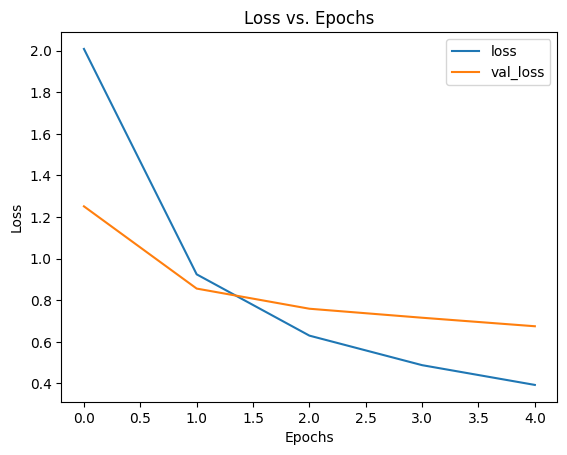

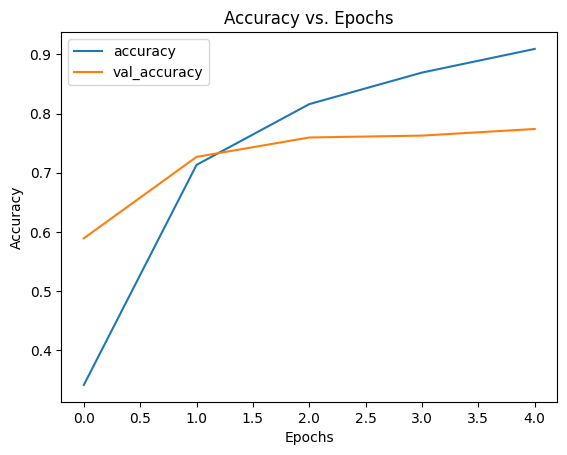

In [17]:
ml_toolbox.analysis.history.plot_history(resnet_history, metric='loss')
ml_toolbox.analysis.history.plot_history(resnet_history, metric='accuracy')

In [18]:
resnet_pred_probs = resnet_model.predict(test_data)
resnet_preds = tf.argmax(resnet_pred_probs, axis=1)

resnet_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data.classes, resnet_preds, name=resnet_name)
resnet_results

79/79 [==============================] - 46s 573ms/step


ClassificationPredictionMetrics(accuracy=0.774, precision=0.7741213499881768, recall=0.774, f1=0.7712536378983729, name='resnet_model')

#### Findings

The resnet model used from transfer learning outperformed all of the CNN networks built in the CNN notebook, by far, in faster time, and with only 10% of the training data.

The validation accuracy ended up at around 77%.

### Experiment-2: Efficientnet Model

The Efficientnet architecture is a powerful, and fast model designed using the CNN archicture that has outperformed many similar models. The paper linked below goes into more detail behind the model.

* https://arxiv.org/pdf/1905.11946v5.pdf

In [19]:
# Constants
efficientnet_name = 'efficientnet_model'

In [21]:
efficientnet_model = create_model(EFFICIENTNET_URL, name=efficientnet_name, img_shape=(IMAGE_SIZE, IMAGE_SIZE))
efficientnet_model.summary()

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'.
INFO:absl:Downloaded https://tfhub.dev/google/efficientnet/b0/feature-vector/1, Total size: 17.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "efficientnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureExtractionLayer (Ke  (None, 1280)              4049564   
 rasLayer)                                                       
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
________________________________________

In [22]:
# Compile model
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=['accuracy'])

# Create Callback
efficientnet_tensorboard_callback = ml_toolbox.modeling.callbacks.generate_tensorboard_callback(efficientnet_name)

# Fit model
efficientnet_model_history = efficientnet_model.fit(train_data,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                                                    validation_data=test_data,
                                                    validation_steps=VAL_STEPS_PER_EPOCH,
                                                    callbacks=[efficientnet_tensorboard_callback])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/efficientnet_model/20230919-195041
Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 1.8253 - accuracy: 0.4320 - val_loss: 1.2833 - val_accuracy: 0.7400
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.0504 - accuracy: 0.7693 - val_loss: 0.8598 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.7472 - accuracy: 0.8293 - val_loss: 0.6944 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6022 - accuracy: 0.8707 - val_loss: 0.6124 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.5099 - accuracy: 0.8853 - val_loss: 0.5589 - val_accuracy: 0.8628


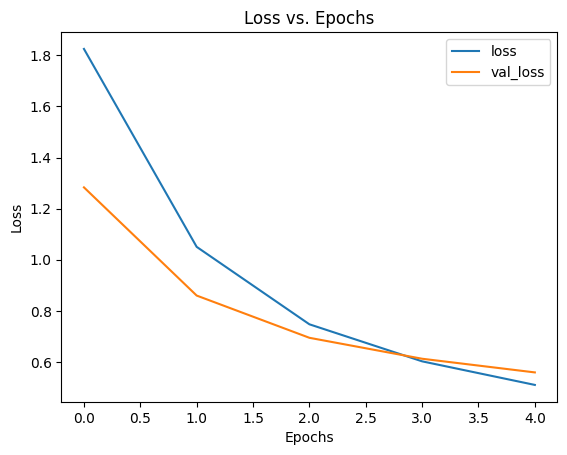

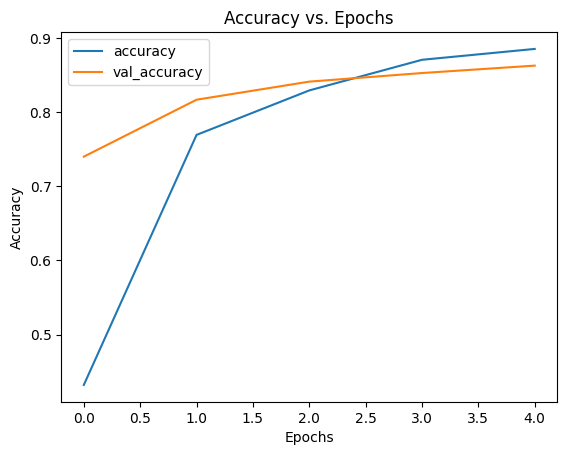

In [23]:
ml_toolbox.analysis.history.plot_history(efficientnet_model_history, metric='loss')
ml_toolbox.analysis.history.plot_history(efficientnet_model_history, metric='accuracy')

In [24]:
efficientnet_pred_probs = efficientnet_model.predict(test_data)
efficientnet_preds = tf.argmax(efficientnet_pred_probs, axis=1)

efficientnet_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data.classes,
                                                                                      efficientnet_preds,
                                                                                      name=efficientnet_name)
efficientnet_results

79/79 [==============================] - 21s 257ms/step


ClassificationPredictionMetrics(accuracy=0.8628, precision=0.8657711445314143, recall=0.8628, f1=0.8631595101980478, name='efficientnet_model')

#### Findings

The efficientnet model used from transfer learning outperformed all of the CNN networks built in the CNN notebook, by far, in faster time, and with only 10% of the training data.

The validation accuracy finished at around 86%.

Compairing this model to the resnet model, it looks like the efficientnet model outperformed the resnet model by about 10%, even though there are less trainable parameters in the efficientnet model.

## Analysis: Comparing Efficientnet Vs. Resnet

Looking at our logs generated with TensorBoard for each run. This uses the tensorboard command located below to upload the logs to TensorBoard, then can be viewed there using the generated link.

**!!NOTE!!** All logs uploaded to TensorBoard are made public, so do NOT upload logs that should remain private!

In [25]:
results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe([resnet_results, efficientnet_results])
results_df

,accuracy,precision,recall,f1
resnet_model,0.7740,0.774121,0.7740,0.771254
efficientnet_model,0.8628,0.865771,0.8628,0.863160


<Axes: >

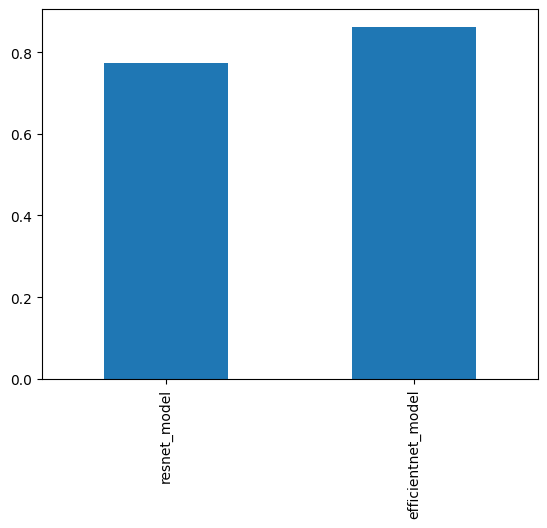

In [26]:
results_df['accuracy'].plot(kind='bar')

In [27]:
# !tensorboard dev upload --logdir ./logs \
#    --name "Efficientnet B0 vs. Resnet 50 V2" \
#    --description "Comparing two different TensorFlow Hub NN architectures." \
#    --one_shot